In [3]:
%reload_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
from pydantic import parse_obj_as
from typing import List
import gc

import matplotlib.pyplot as plt
import mlflow

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sales_forecasting.api.model import RequestSchema
from sales_forecasting.utils.feature_engineering import calendar_features, incomplete_data_stores
from sales_forecasting.utils.evaluation import  results_df, results_keeper, final_results_keeper, prediction_metrics_and_result_keeper, smape, error, store_train_test_selection, model_selection_specific_store
from lightgbm import LGBMRegressor

In [6]:
models=[]
daily_smape=[]
weekly_smape=[]
monthly_smape=[]
percentage_error_model=[]
list_of_incomplete_stores=[]
store=[]


In [7]:
raw_sales_data = pd.read_csv('../data/sales_per_store_per_day.csv', 
    dtype={'Store':'Int64','DayOfWeek':'Int64','Sales':'Int64','Customers':'Int64','Open':'Int64','Promo':'Int64','StateHoliday':'str','SchoolHoliday':'Int64'}, parse_dates=['Date'])

raw_dict=raw_sales_data.to_dict(orient='records')
validated_sales=parse_obj_as(List[RequestSchema], raw_dict)

del raw_sales_data, raw_dict
gc.collect()

sales_df=pd.DataFrame([item.dict() for item in validated_sales])
del validated_sales 
gc.collect()

0

## Feature engineering

In [8]:
sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
sales_df['close_flag'] = np.where(sales_df['open_flag'] == 1, 0, 1)
sales_df['state_holiday_flag']=np.where(sales_df['state_holiday'] == '0', 0, 1)
sales_df = calendar_features(sales_df)
sales_df['week_of_year'] = sales_df['week_of_year'].astype(int)

### Explore Machine Learning models on one store

In [9]:
one_store = sales_df[sales_df['store']==85].copy()
train_data = one_store[one_store['sales_date'] < datetime(2015,2,28)].copy()
test_data = one_store[one_store['sales_date'] >= datetime(2015,2,28)].copy()

x_train = train_data.drop(columns=['sales_date','store','sales','customers','state_holiday'])
y_train = train_data['sales']

x_test = test_data.drop(columns=['sales_date','store','sales','customers','state_holiday'])
y_test = test_data['sales']

## LGBMRegressor

Total value of sales on test predicted interval: 940336
Absolute error:  111907
Percentage error reported to real sales: 0.56%
Daily SMAPE is: 5.74 %
Weekly SMAPE is: 3.07 %
Monthly SMAPE is: 2.46 %


c:\Users\Andreea_Deselnicu\AppData\Local\pypoetry\Cache\virtualenvs\sales-forecasting-Jq6dvf6y-py3.10\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


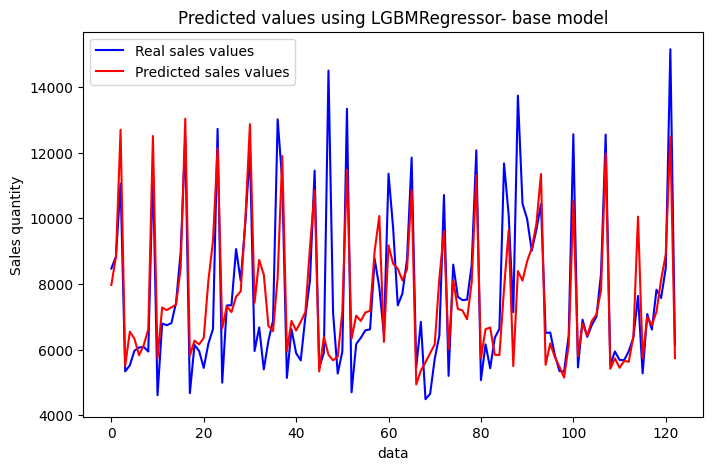

In [10]:
EXPERIMENT_NAME = "sales_forecasting"
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='base_model') as run:
    # Retrieve run id
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    mlflow.log_metric('daily_smape', daily_smape[0])
    mlflow.log_metric('weekly_smape', weekly_smape[0])
    mlflow.log_metric('monthly_smape', monthly_smape[0])
    mlflow.lightgbm.log_model(model, 'model')

    plt.figure(figsize=(8,5))  
    plt.plot(y_test.values, color='blue', label='Real sales values')  
    plt.plot(y_pred_lgb , color='red', label='Predicted sales values')  
    plt.title('Predicted values using LGBMRegressor- base model')  
    plt.xlabel('data')  
    plt.ylabel('Sales quantity')  
    plt.legend()
    plt.savefig("real_vs_predicted.png")  
    plt.show()
    mlflow.log_artifact("real_vs_predicted.png")

## Hyperparameter optimization using Optuna

In [17]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    
    param = {
        'metric': 'rmse', 
        'random_state': 1,
        'n_estimators': 50,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,30]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    model = LGBMRegressor(**param)  
    model.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(x_test)
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse

In [20]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-12 15:19:26,099] A new study created in memory with name: no-name-3957d585-b068-490e-9b79-7164488c1370
[I 2023-05-12 15:19:26,112] Trial 0 finished with value: 2428.4764119357 and parameters: {'reg_alpha': 0.0025826470728118633, 'reg_lambda': 0.017849398660079525, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 30, 'num_leaves': 2, 'min_child_samples': 199}. Best is trial 0 with value: 2428.4764119357.
[I 2023-05-12 15:19:26,130] Trial 1 finished with value: 2454.465115891787 and parameters: {'reg_alpha': 0.17332825949450356, 'reg_lambda': 0.19729467472546036, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 5, 'min_child_samples': 229}. Best is trial 0 with value: 2428.4764119357.
[I 2023-05-12 15:19:26,160] Trial 2 finished with value: 2441.369458814525 and parameters: {'reg_alpha': 0.29211061971375285, 'reg_lambda': 0.005874625664895186, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_ra

Number of finished trials: 50
Best trial: {'reg_alpha': 0.10314009420017613, 'reg_lambda': 0.0010332393867614927, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 8, 'min_child_samples': 2}


In [25]:
best_lgbm_params=study.best_params

Total value of sales on test predicted interval: 940336
Absolute error:  102883
Percentage error reported to real sales: 4.44%
Daily SMAPE is: 5.22 %
Weekly SMAPE is: 2.71 %
Monthly SMAPE is: 3.45 %


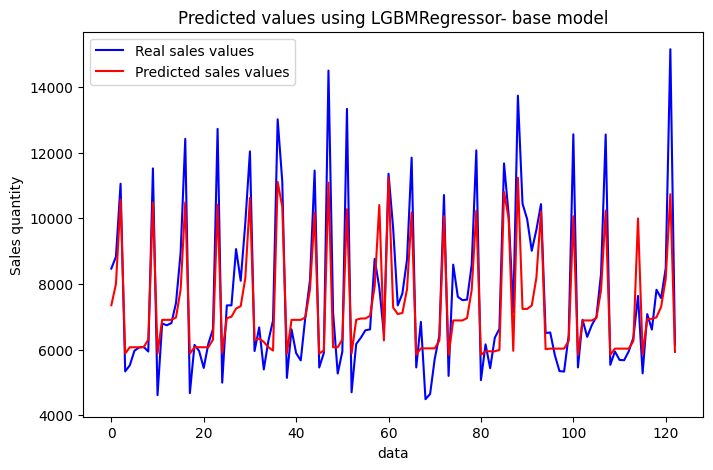

In [26]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimizedt_lgbm') as run:
    # Retrieve run id
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model.set_params(**best_lgbm_params)
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    mlflow.log_metric('daily_smape', daily_smape[1])
    mlflow.log_metric('weekly_smape', weekly_smape[1])
    mlflow.log_metric('monthly_smape', monthly_smape[1])
    mlflow.lightgbm.log_model(model, 'model')

    plt.figure(figsize=(8,5))  
    plt.plot(y_test.values, color='blue', label='Real sales values')  
    plt.plot(y_pred_lgb , color='red', label='Predicted sales values')  
    plt.title('Predicted values using LGBMRegressor- base model')  
    plt.xlabel('data')  
    plt.ylabel('Sales quantity')  
    plt.legend()
    plt.savefig("real_vs_predicted.png")  
    plt.show()
    mlflow.log_artifact("real_vs_predicted.png")

## Prophet

In [24]:
one_store_prophet = one_store.copy()
one_store_prophet.rename(columns={'sales_date':'ds','sales':'y'}, inplace=True)

train_data_prophet = one_store_prophet[one_store_prophet['ds'] < datetime(2015,2,28)].copy()
test_data_prophet = one_store_prophet[one_store_prophet['ds'] >= datetime(2015,2,28)].copy()

one_store_prophet_holidays = train_data_prophet[(train_data_prophet['state_holiday']!="0") | (train_data_prophet['school_holiday']!=0) | (train_data_prophet['promo']!=0) ][['ds','state_holiday']].copy()

one_store_prophet_holidays['state_holiday']=np.where(one_store_prophet_holidays['state_holiday']=='b','Easter',one_store_prophet_holidays['state_holiday'])
one_store_prophet_holidays['state_holiday']=np.where(one_store_prophet_holidays['state_holiday']=='c','Christmas',one_store_prophet_holidays['state_holiday'])
one_store_prophet_holidays['state_holiday']=np.where(one_store_prophet_holidays['state_holiday']=='a','Other state holidays',one_store_prophet_holidays['state_holiday'])

one_store_prophet_holidays.rename(columns={'state_holiday':'holiday'}, inplace=True)

In [25]:
prophet_model = Prophet(daily_seasonality=False, holidays=one_store_prophet_holidays)
prophet_model.fit(train_data_prophet)
future_prophet = prophet_model.make_future_dataframe(periods=123)
prophet_predictions=prophet_model.predict(future_prophet)
#set predictions to int values and modify negative predictions to 0
prophet_predictions['yhat'] = np.where(prophet_predictions['yhat'] < 0, 0, prophet_predictions['yhat']).astype('int')
prophet_predictions = prophet_predictions[prophet_predictions['ds'] >= datetime(2015,2,28)].copy()

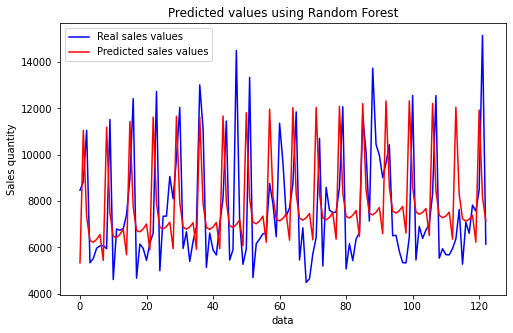

In [26]:
plt.figure(figsize=(8,5))  
plt.plot(test_data_prophet['y'].values, color='blue', label='Real sales values')  
plt.plot(prophet_predictions['yhat'].values , color='red', label='Predicted sales values')  
plt.title('Predicted values using Random Forest')  
plt.xlabel('data')  
plt.ylabel('Sales quantity')  
plt.legend()  
plt.show()

In [42]:
models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(test_data_prophet['y'].values, prophet_predictions['yhat'].values, prophet_model)

Total value of sales on test predicted interval: 940336
Absolute error:  244514
Percentage error reported to real sales: 2.25%
Daily SMAPE is: 12.03 %
Weekly SMAPE is: 4.31 %
Monthly SMAPE is: 2.1 %


## Comparative results

In [43]:
# create a model selection dataframe for best model determination
model_selection = pd.DataFrame({'Model': models, 'daily_smape': daily_smape, 'weekly_smape': weekly_smape, 'monthly_smape' :monthly_smape, 'percentage_error': percentage_error_model})
model_selection.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection.style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Model,daily_smape,weekly_smape,monthly_smape,percentage_error
1,fbprophet,12.030000,4.310000,2.100000,2.250000
0,RandomForestRegressor,4.280000,2.230000,1.900000,1.950000


## Predict using RandomForest on all stores

#### Use Random Forest differently on nonstop stores, incomplete data range stores and others

In [15]:
# get all stores categories (nonstop, normal and stores with incomplete data)
all_stores = sales_df['store'].unique()
nonstop_stores = sales_df.groupby(['store', 'open_flag']).agg({
    'customers':'sum',
    'sales':'sum'
})

nonstop_stores.reset_index(inplace=True)
nonstop_stores['close_flag'] = np.where(nonstop_stores['open_flag']==0, 1, 0)

nonstop_stores=nonstop_stores.groupby(['store']).agg({
    'customers':'sum',
    'sales':'sum',
    'close_flag':'sum'})
nonstop_stores = nonstop_stores[nonstop_stores['close_flag']!=1]
nonstop_stores = list(nonstop_stores.index)


incomplete_stores = incomplete_data_stores(sales_df)
normal_stores=[store for store in all_stores if (store not in nonstop_stores) & (store not in incomplete_stores) ]

### Grid search for nonstop stores

In [16]:
nonstop_stores

[85, 262, 335, 423, 494, 562, 682, 733, 769, 1097]

In [38]:
x_train, y_train, x_test,  y_test = store_train_test_selection(sales_df,store_number=85)
  # Create the parameter grid based on the results of random search 
param = {
    'bootstrap': [True],
    'max_depth': [ 56, 58],
    'max_features': [6,11],
    'min_samples_leaf': [3,2],
    'min_samples_split': [5],
    'n_estimators':[15]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param, cv = 5, scoring='neg_mean_absolute_percentage_error')
grid.fit(x_train, y_train)

print("The best params are: ", grid.best_params_)
print("The best negative mean absolute percentage error is: ",grid.best_score_)

random_forest_nontstop_store = RandomForestRegressor(bootstrap = True, max_depth = 58, max_features= 6, min_samples_leaf= 2, min_samples_split= 5, n_estimators=15)

The best params are:  {'bootstrap': True, 'max_depth': 56, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 15}
The best negative mean absolute percentage error is:  -0.08794606656238171


In [53]:
models = []
daily_smape = [] 
weekly_smape = [] 
monthly_smape = []
percentage_error = []
store = []

# get predictions for all nonstop stores
for i in range(len(nonstop_stores)):
    x_train, y_train, x_test, y_test = store_train_test_selection(sales_df,store_number=nonstop_stores[i])
    random_forest_model_current_store=random_forest_nontstop_store.fit(x_train, y_train)
    y_pred_rf = random_forest_model_current_store.predict(x_test)
    model_selection_nonstop_stores=model_selection_specific_store(random_forest_model_current_store,y_test, y_pred_rf, 'model_selection_nonstop_stores', nonstop_stores[i])
    

In [54]:
model_selection_nonstop_stores.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection_nonstop_stores.style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())


,Store,daily_smape,weekly_smape,monthly_smape,percentage_error
2,335,5.280000,4.480000,4.330000,8.550000
3,423,5.020000,3.280000,2.840000,4.240000
0,85,4.320000,2.250000,2.240000,2.020000
8,769,4.180000,3.030000,3.480000,5.580000
4,494,3.720000,1.530000,1.620000,2.220000
7,733,3.480000,2.070000,1.300000,2.550000
6,682,3.260000,1.990000,1.860000,3.560000
1,262,2.990000,1.460000,0.710000,0.250000
9,1097,2.880000,2.020000,1.560000,2.610000
5,562,2.470000,1.480000,0.970000,0.590000


### Normal Stores

In [56]:
x_train, y_train, x_test,  y_test = store_train_test_selection(sales_df,store_number=1)
  # Create the parameter grid based on the results of random search 
param = {
    'bootstrap': [True],
    'max_depth': [ 56, 58],
    'max_features': [6,11, 7],
    'min_samples_leaf': [3,2,4,6],
    'min_samples_split': [5,7,3],
    'n_estimators':[15,20,16, 13]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param, cv = 5, scoring='neg_mean_absolute_percentage_error')
grid.fit(x_train, y_train)

print("The best params are: ", grid.best_params_)
print("The best negative mean absolute percentage error is: ",grid.best_score_)


The best params are:  {'bootstrap': True, 'max_depth': 58, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 16}
The best negative mean absolute percentage error is:  -0.08527631413468817


In [60]:
random_forest_normal_store = RandomForestRegressor(bootstrap = True, max_depth = 56, max_features= 7, min_samples_leaf= 2, min_samples_split= 5, n_estimators=16)

models = []
daily_smape = [] 
weekly_smape = [] 
monthly_smape = []
percentage_error = []
store = []

# get predictions for all nonstop stores
for i in range(len(normal_stores)):
    x_train, y_train, x_test, y_test = store_train_test_selection(sales_df,store_number=normal_stores[i])
    random_forest_model_current_store=random_forest_normal_store.fit(x_train, y_train)
    y_pred_rf = random_forest_model_current_store.predict(x_test)
    model_selection_normal_stores=model_selection_specific_store(random_forest_model_current_store,y_test, y_pred_rf, 'model_selection_normal_stores', normal_stores[i])

In [61]:
model_selection_normal_stores.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection_normal_stores.head(4).style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Store,daily_smape,weekly_smape,monthly_smape,percentage_error
485,576,13.540000,13.050000,11.650000,24.950000
813,971,11.680000,13.150000,4.910000,9.730000
564,674,10.760000,25.920000,24.260000,3.220000
610,732,10.510000,5.290000,2.910000,0.230000


### Incomplete stores

In [62]:
one_store=sales_df[sales_df['store']==13].copy()
# consider gap data as closed store
store_data_range = pd.date_range(start=one_store['sales_date'].min(), end=one_store['sales_date'].max(), freq='d')
store_data_range.name = 'sales_date'
one_store=one_store.set_index('sales_date').reindex(store_data_range).fillna(0).reset_index().copy()
#recreate features for gap data
one_store['store']=np.where(one_store['store']==0,13,one_store['store'])
one_store = calendar_features(one_store)
one_store['day_of_week']=one_store['sales_date'].dt.day_of_week +1

In [67]:
x_train, y_train, x_test,  y_test = store_train_test_selection(sales_df,store_number=13)
  # Create the parameter grid based on the results of random search 
param = {
    'bootstrap': [True],
    'max_depth': [ 56, 58],
    'max_features': [6,11, 7],
    'min_samples_leaf': [3,2,4,6],
    'min_samples_split': [5,7,3],
    'n_estimators':[15,20,16, 13]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param, cv = 5, scoring='neg_mean_absolute_percentage_error')
grid.fit(x_train, y_train)

print("The best params are: ", grid.best_params_)
print("The best negative mean absolute percentage error is: ",grid.best_score_)


The best params are:  {'bootstrap': True, 'max_depth': 56, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 15}
The best negative mean absolute percentage error is:  -0.08486823472359081


In [68]:
random_forest_incomplete_store = RandomForestRegressor(bootstrap = True, max_depth = 56, max_features= 11, min_samples_leaf= 4, min_samples_split= 7, n_estimators=20)

models = []
daily_smape = [] 
weekly_smape = [] 
monthly_smape = []
percentage_error = []
store = []

# get predictions for all nonstop stores
for i in range(len(incomplete_stores)):
    one_store=sales_df[sales_df['store']==incomplete_stores[i]].copy()
    # consider gap data as closed store
    store_data_range = pd.date_range(start=one_store['sales_date'].min(), end=one_store['sales_date'].max(), freq='d')
    store_data_range.name = 'sales_date'
    one_store=one_store.set_index('sales_date').reindex(store_data_range).fillna(0).reset_index().copy()
    #recreate features for gap data
    one_store['store']=np.where(one_store['store']==0,incomplete_stores[i],one_store['store'])
    one_store = calendar_features(one_store)
    one_store['day_of_week']=one_store['sales_date'].dt.day_of_week +1

    x_train, y_train, x_test, y_test = store_train_test_selection(one_store,store_number=incomplete_stores[i])

    random_forest_model_current_store=random_forest_incomplete_store.fit(x_train, y_train)
    y_pred_rf = random_forest_model_current_store.predict(x_test)

    predictions=results_df(y_test=y_test, y_hat=y_pred_rf)
    weekly_metrics=predictions.groupby(['week_group']).sum()
    monthly_metrics=predictions.groupby(['month_group']).sum() 

    #Get daily, weekly and monthly error values

    daily_error_smape=smape(predictions['real_sales'], predictions['predicted_sales'])
    weekly_error_smape=smape(weekly_metrics['real_sales'],weekly_metrics['predicted_sales'])
    monthly_error_smape=smape(monthly_metrics['real_sales'],monthly_metrics['predicted_sales'])
    percentage_error_rf=round(np.abs(predictions["real_sales"].sum()-predictions["predicted_sales"].sum())/predictions["real_sales"].sum()*100,2)

    models, daily_smape, weekly_smape, monthly_smape, percentage_error, store = final_results_keeper(random_forest_model_current_store, daily_error_smape, weekly_error_smape, monthly_error_smape, percentage_error_rf, store_value=incomplete_stores[i])

model_selection_incomplete_stores = pd.DataFrame({'Store': store, 'daily_smape': daily_smape, 'weekly_smape': weekly_smape, 'monthly_smape' :monthly_smape,'percentage_error':     percentage_error})
model_selection_incomplete_stores.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection_incomplete_stores.head(4).style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Store,daily_smape,weekly_smape,monthly_smape,percentage_error
485,576,13.540000,13.050000,11.650000,24.950000
813,971,11.680000,13.150000,4.910000,9.730000
564,674,10.760000,25.920000,24.260000,3.220000
610,732,10.510000,5.290000,2.910000,0.230000


### All stores metrics

In [77]:
final_results_all_stores = pd.concat([model_selection_nonstop_stores, model_selection_normal_stores, model_selection_incomplete_stores])
final_results_all_stores.drop_duplicates(inplace=True)

In [78]:
final_results_all_stores[final_results_all_stores['daily_smape'] == final_results_all_stores['daily_smape'].min()]

,Store,daily_smape,weekly_smape,monthly_smape,percentage_error
1013,498,2.08,1.46,1.59,1.25


In [79]:
final_results_all_stores[final_results_all_stores['daily_smape'] == final_results_all_stores['daily_smape'].max()]

,Store,daily_smape,weekly_smape,monthly_smape,percentage_error
485,576,13.54,13.05,11.65,24.95


In [80]:
final_results_all_stores['daily_smape'].mean()

4.218834080717489